In [1]:
try:
    %load_ext autotime
except:
    %pip install ipython-autotime
    %load_ext autotime

Note: you may need to restart the kernel to use updated packages.
time: 198 µs (started: 2023-11-21 20:06:21 -08:00)


# Exact Approaches for Solving TSPs

We will go over some exact approaches including the famous Held-Karp algorithm, followed by some approaches based on integer linear programs.

Recall that a TSP instance consists of a complete weighted directed graph with $n$ nodes. Here a graph is complete if for all pairs of vertices $i, j$ with $i \not= j$, the edges $(i,j)$ and $(j,i)$ exist. The edge $(i,j)$ is associated with a cost $c_{ij}$. 

Note that an instance is symmetric if $c_{ij} = c_{ji}$ for all pairs $i,j$. The exact approaches below work on general, possibly asymmetric TSPs.


A simple _brute force_ approach works as follows:
  - Go through all possible permutations of the numbers $1, \ldots, n$: there are $n!$ such permutations.
  - Each permutation denotes a possible TSP tour. Compute its cost by summing up all the edge weights.
  - Retain the permutation with the minimum cost.
  
The algorithm is simple, but its running time is $O(n \times n!)$. This is because we go through $n!$ permutations in total with each permutation requiring $O(n)$ time to compute its cost.

Can we do better than the brute force approach above? Indeed: we will now look at a dynamic programming algorithm by Held and Karp which solves the problem in time $O(n^2 2^n)$ for an instance with $n$ nodes.

## Held and Karp's Algorithm

This algorithm was proposed by Bellman (who pioneered dynamic programming) and Held and Karp in 1962: 

<div class="alert alert-block alert-info" style="border-color:white white white black">

Richard Bellman, Dynamic programming treatment of the travelling salesman problem, J. Assoc. Comput. Mach., 9 (1962), 61–63

<p>
    
Michael Held and Richard M. Karp, "A dynamic programming approach to sequencing problems",  Journal for the Society for Industrial and Applied Mathematics (1962), 1-10.
</div>


The key idea is to think of constructing a TSP tour in terms of _combinations_ (where we try to delay specifying the precise order in which nodes are visited, as much as possible) rather than _permutations_. To do so, it is convenient to think about paths rather than cycles. 

The key idea is to express a TSP tour in terms of finding paths through a set of nodes ending at a designated vertex. Once we do that, we develop a dynamic programming algorithm.

Note that Held-Karp algorithm works for arbitrary TSPs.

### Basic Idea Behind Held-Karp Algorithm

The first step is to think about a TSP tour as follows: 
  - We arbitrarily designate vertex $1$ as the "start" and "end" points of the tour. A different node can be chosen instead of $1$ but it does not matter to the overall operation of the algorithm.
  - Next, we think of the TSP tour as starting from vertex $1$, and a path that visits the vertices in the set $\{2, \ldots, n-1\}$ precisely once and returning back to vertex $1$. 
  
Let $S$ be a subset of vertices $\{2, \ldots, n\}$ and $e \not\in S$ be a designated vertex (assume $e \not= 1$):

$\newcommand\minCostPath{\mathsf{minCostPath}}$
Let us introduce  $\minCostPath(S, e)$ as the cost of the shortest path in the graph that satisfies the following constraints:
  - The path starts from vertex $1$, 
  - The path visits each of the vertices in $S$ _precisely_ once, 
  - The path visits vertex $e$ and stops.
  
<div class="alert alert-block alert-success">
    If we can compute $\minCostPath(S, e)$ for any subset $S \subseteq \{2, \ldots, n-1\}$ and vertex $e$ such that $e \not= 1$ and $e \not\in S$ then we can solve the original minimum cost TSP tour using $\minCostPath$.
</div>

$\newcommand\minTSP{\mathsf{minTSP}}$
Let $\minTSP(n, C )$ be the minimum TSP tour on an instance given by a complete graph of size $n$ and costs given by a  matrix $C$, where $C_{ij}$ is the cost of going fron $i$ to $j$. We need not assume that the TSP is symmetric. I.e, $C_{i,j}$ need not be the same as $C_{j,i}$, in general.

The following equation relates the cost of the optimal TSP tour against the minimum path cost.

$$\minTSP(n, C) = \min_{e=2}^n \left\{  \minCostPath\left(\{2, 3, \ldots, n\} \setminus \{e\}, e\right) + C_{e,1} \right\} $$

In other words, to compute the minimum TSP tour, just run through end points $e = 2, \ldots, n$ and 
  1. Find a minimum cost path that goes through all nodes $2, \ldots, n$ other than $e$, and ends at $e$,
  2. Add the value of $C_{e,1}$ to return back to node $1$.

The minimum value of $e$ among all these choices yields the cost of the minimum TSP. The image below illustrates this concept.

<img src="attachment:held-karp-illustr.jpeg" width="60%"></img>

### Dynamic Programming for $\minCostPath$

We will now think about how to dynamic program for $\minCostPath(S, e)$ for a given set of vertices $S$ and $e \not\in S$.  We approach it in four parts:
  1. Stage the decisions we need to make and identify the optimal sub-structure.
  2. Create a recurrence.
  3. Memoize and compute value function.
  4. Recover the solution.
 
#### Staging Decisions + Optimal Substructure
The key decision that we need to make for $\minCostPath(S, e)$ is "which order to visit the nodes in $S$". We can stage this in multiple ways but the simplest one is to _decide the last but one vertex in the path_ (or the vertex that comes immediately before the end point $e$). This vertex has to be part of the set $S$. 

Once we fix a vertex $s \in S$ as the one that occurs immediately before $e$, we have to find the best path that goes through $S \setminus \{s\}$ and ends up in the node $s$. We can then traverse the edge $(s, e)$ to complete the original task of ending up in $e$.

Optimal substructure tells us that to find $\minCostPath(S, e)$, we commit to a last-but-one node $s \in S$. What is left over is in turn to find $\minCostPath(S,s)$. I.e, the optimal solution to the former problem contains within it an optimal solution to the latter problem. 

#### Recurrence 
Thus suggests the following recurrence if $S \not = \emptyset $.

$$ \minCostPath(S, e) = \min_{s \in S}\ \left( \minCostPath(S \setminus \{s\}, s) + C_{se} \right) \,.$$

If $S = \emptyset$ then note that $\minCostPath(\emptyset, e) = C_{1,e}$ the cost of going from vertex $1$ directly to end point.

#### Memoization

The memoization here is different from what we are used to. Our memo table has cells which are labeled by two arguments $S \subseteq \{2, \ldots, n\}$ and $e \not\in S$ (also $e \not= 1$). We have $O(2^{n-1} \times (n-1))$ such cells in our table.

Note that the recurrence $$ \minCostPath(S, e) = \min_{s \in S}\ \left( \minCostPath(S \setminus \{s\}, s) + C_{se} \right) \,.$$ 

tells us that we need to fill the table for sets $S$ of increasing sizes starting from sets of sizes $1$ and moving up to sets of sizes $n-1$.

#### Recovering the Solution

In order to recover the solution, we will label each cell corresponding to $\minCostPath(S, e)$ with an element $s \in S$ that produces the minimum value for our recurrence:

$$ \minCostPath(S, e) = \min_{s \in S}\ \left( \minCostPath(S \setminus \{s\}, s) + C_{se} \right) \,.$$

Once we have this, we can recover the path as follows: 
  - Let $s_1 \in S $ be the minimizing solution $ \minCostPath(S, e)$.
  - Let $s_2 \in S \setminus \{s_1\}$ be the minimizing solution to $ \minCostPath(S\setminus \{s_1\}, s_1)$.
  - Let $s_3 \in S \setminus \{s_1, s_2\}$ be the minimizing solution to $ \minCostPath(S\setminus \{s_1, s_2\}, s_2)$.
  - ...
  - Let $s_k \in S \setminus \{s_1, \ldots, s_{k-1}\}$ be the minimizing solution to $\minCostPath(S\setminus \{s_1, s_2, \ldots, s_{k-1}\}, s_{k-1})$.

Assuming that $S = \{ s_1, \ldots, s_{k} \}$ then we hit the base case at the last step. The path will then be
$$1 \rightarrow s_{k} \rightarrow s_{k-1} \cdots \rightarrow s_{1} \rightarrow e $$

We are ready to code this up in Python. The difficulty lies in designing a data structure for the memo table each of whose entries are indexed by a set $S$ and a vertex $e$. We will use a list of python dictionaries to store our memo table in our implementation. The code is below and the comments serve to explain its workings.

In [2]:
def memoize_min_cost_path(n, cost_matrix, debug=False):
    ## Maintaining a memo table and iterating through all sets of size $k$ systematically is  very tricky.
    ## We will just use inbuilt python data structures for this task.
    tbl = [] # Our table is simply a list of dictionaries. Each dictionary in our list is a memo table for sets of a fixed size $j$
    sol_tbl = [] # corresponding to tbl, we will hold the minimizing entry in sol_tbl to be able to recover the solution
    # tbl[i] is a dictionary that will hold all sets $S$ of size $i$ and end points e.
    # Also note that while we presented our algorithm to start from index 1, we will 
    # start our code from index 0. Therefore, vertex 0 is the starting point.
    assert len(cost_matrix) == n, f'Cost matrix is not {n}x{n}'
    assert all(len(cj) == n for cj in cost_matrix), f'Cost matrix is not {n}x{n}'
    # start by seeding the dictionary with S = emptyset
    mcp0 = {}
    sol0 = {}
    for e in range(1, n):
        S = frozenset() # frozenset in Python is an immutable set that can be hashed
        mcp0[(S, e)] = cost_matrix[0][e] # this is the base case when S = \emptyset as explained in notes above.
        sol0[(S, e)] = 0 # the previous vertex is just the start vertex 0
    tbl.append(mcp0) # add the "cost-to-go" dictionary to table
    sol_tbl.append(sol0) # add the solution dictionary to the solution table.
    ## now build up for set sizes from 1 to n-1. Set size 0 is already built and added to list at start.
    for size in range(1, n-1):
        mcp_prev = tbl[-1] # fetch the table for sets of size $n-1$.
        mcp = {} # initialize the current table
        sol = {} # initialize the current solution table
        # run through all sets of cardinality size-1
        for ((S, s), v) in mcp_prev.items():  
            assert len(S) == size-1, 'invariant failed -- the algorithm has been implemented wrong if this assertion fails'
            S_new = S.union(frozenset({s})) # make S_new = S Union {s}
            for e in range(1, n): # run through all possible end points 
                if e in S_new: # skip all end points already in the set S_new
                    continue
                new_path_cost = v + cost_matrix[s][e] # compute path cost using recursion
                old_path_cost = mcp.get((S_new, e)) # if the entry has already been added to the dictionary look it up
                old_sol = sol.get((S_new, e))
                if old_path_cost == None or old_path_cost > new_path_cost:  # if entry is not already in dictionary or tthe current solution is better than previous, replace
                    mcp[(S_new, e)] = new_path_cost
                    sol[(S_new, e)] = s
        tbl.append(mcp) # mcp is the memo table for sets of cardinality equal to the loop index size
        sol_tbl.append(sol) # sol_tbl is to be appended as well.
        if debug: # print stuff for our debugging
            print(f'Sets of size {size}')
            for ((S,e), v) in mcp.items():
                print(f'\t {S}, {e} --> {v}')
    ## Now compute best TSP tour and recover solution.
    mcp = tbl[-1] # pick up last entry 
    sol = sol_tbl[-1] 
    
    min_cost_tour = float('inf')
    end_pt = None
    # Now find the best TSP tour by using the equation that relates minCostPath to minTSPTour
    for e in range(1, n): # run through all end points
        S = frozenset({i for i in range(1, n) if i != e}) # create set S of all vertices other than e
        assert (S,e) in sol  
        v = mcp[(S,e)] # look up minCostPath(S,e)
        if v + cost_matrix[e][0] < min_cost_tour: # add the cost of retutrning from end point e to 0 to v
            min_cost_tour =  v + cost_matrix[e][0] # is it better than previous solution, if so replace.
            end_pt = e
    if debug:
        print(f'Minimum cost TSP tour: {min_cost_tour}')
        print(f'Last vertex visited before cycling back: {e}')
    # end_pt is the last vertex before cycling back to vertex 0.
    # Let's recover the tour now in the reverse order
    tour = [end_pt]
    S = frozenset({j for j in range(1, n) if j != end_pt}) # this is the set of nodes to visit
    for i in range(n-2, 0, -1):
        assert len(S) == i, f'{len(S)}, {i}'
        sol = sol_tbl[i]
        e = tour[-1]
        assert (S, e) in sol, f'Entry {(S,e)} missing from solution table: {sol}'
        new_end_pt = sol[(S,e)]
        if debug:
            print(f'Recovering solution: looking up sol[{(S, e)}] -> new end point: {new_end_pt}')
        assert new_end_pt in S
        tour.append(new_end_pt) # add new end point to the tour but remember to reverse the whole list at the end or else tour will be in reverse order 
        S = frozenset({j for j in S if j != new_end_pt}) # remove new_end_pt from the set S
        assert len(S) == i-1, f'{len(S)}, {i-1}'
    tour.append(0)
    tour.reverse() # reverse the tour since we have been appending to the end
    if debug:
        print(f'Tour:{tour}, cost: {min_cost_tour}')
    return tour, min_cost_tour
    

time: 3.21 ms (started: 2023-11-21 20:06:31 -08:00)


In [3]:
cost_matrix = [ [ 0, 1, 3, 4],
                [ 1, 0, 2, 3 ], 
                [ 3, 2, 0, 4 ], 
                [ 4, 3, 4, 0]]

memoize_min_cost_path(4, cost_matrix, True)

Sets of size 1
	 frozenset({1}), 2 --> 3
	 frozenset({1}), 3 --> 4
	 frozenset({2}), 1 --> 5
	 frozenset({2}), 3 --> 7
	 frozenset({3}), 1 --> 7
	 frozenset({3}), 2 --> 8
Sets of size 2
	 frozenset({1, 2}), 3 --> 7
	 frozenset({1, 3}), 2 --> 8
	 frozenset({2, 3}), 1 --> 10
Minimum cost TSP tour: 11
Last vertex visited before cycling back: 3
Recovering solution: looking up sol[(frozenset({2, 3}), 1)] -> new end point: 3
Recovering solution: looking up sol[(frozenset({2}), 3)] -> new end point: 2
Tour:[0, 2, 3, 1], cost: 11


([0, 2, 3, 1], 11)

time: 5.82 ms (started: 2023-11-21 20:06:37 -08:00)


In [4]:
cost_matrix = [ [ 0, 1, 3, 4, 2 ],
                [ 1, 0, 2, 3, 1 ], 
                [ 3, 2, 0, 4 , 3], 
                [ 4, 3, 4, 0, 4 ],
                [ 2, 1, 3, 4, 0 ]]

memoize_min_cost_path(5, cost_matrix, True)

Sets of size 1
	 frozenset({1}), 2 --> 3
	 frozenset({1}), 3 --> 4
	 frozenset({1}), 4 --> 2
	 frozenset({2}), 1 --> 5
	 frozenset({2}), 3 --> 7
	 frozenset({2}), 4 --> 6
	 frozenset({3}), 1 --> 7
	 frozenset({3}), 2 --> 8
	 frozenset({3}), 4 --> 8
	 frozenset({4}), 1 --> 3
	 frozenset({4}), 2 --> 5
	 frozenset({4}), 3 --> 6
Sets of size 2
	 frozenset({1, 2}), 3 --> 7
	 frozenset({1, 2}), 4 --> 6
	 frozenset({1, 3}), 2 --> 8
	 frozenset({1, 3}), 4 --> 8
	 frozenset({1, 4}), 2 --> 5
	 frozenset({1, 4}), 3 --> 6
	 frozenset({2, 3}), 1 --> 10
	 frozenset({2, 3}), 4 --> 11
	 frozenset({2, 4}), 1 --> 7
	 frozenset({2, 4}), 3 --> 9
	 frozenset({3, 4}), 1 --> 9
	 frozenset({3, 4}), 2 --> 10
Sets of size 3
	 frozenset({1, 2, 3}), 4 --> 11
	 frozenset({1, 2, 4}), 3 --> 9
	 frozenset({1, 3, 4}), 2 --> 10
	 frozenset({2, 3, 4}), 1 --> 12
Minimum cost TSP tour: 13
Last vertex visited before cycling back: 4
Recovering solution: looking up sol[(frozenset({2, 3, 4}), 1)] -> new end point: 4
Recoverin

([0, 2, 3, 4, 1], 13)

time: 3.21 ms (started: 2023-11-21 20:10:16 -08:00)


In [5]:
cost_matrix = [
    [ 0, 12, 10, 19, 8],
    [ 12, 0, 3, 7, 19],
    [ 10, 3, 0, 6, 20],
    [ 19, 7, 6, 0, 4],
    [ 8, 19, 20, 4, 0]
]
memoize_min_cost_path(5, cost_matrix, True)

Sets of size 1
	 frozenset({1}), 2 --> 15
	 frozenset({1}), 3 --> 19
	 frozenset({1}), 4 --> 31
	 frozenset({2}), 1 --> 13
	 frozenset({2}), 3 --> 16
	 frozenset({2}), 4 --> 30
	 frozenset({3}), 1 --> 26
	 frozenset({3}), 2 --> 25
	 frozenset({3}), 4 --> 23
	 frozenset({4}), 1 --> 27
	 frozenset({4}), 2 --> 28
	 frozenset({4}), 3 --> 12
Sets of size 2
	 frozenset({1, 2}), 3 --> 20
	 frozenset({1, 2}), 4 --> 32
	 frozenset({1, 3}), 2 --> 25
	 frozenset({1, 3}), 4 --> 23
	 frozenset({1, 4}), 2 --> 30
	 frozenset({1, 4}), 3 --> 34
	 frozenset({2, 3}), 1 --> 23
	 frozenset({2, 3}), 4 --> 20
	 frozenset({2, 4}), 1 --> 31
	 frozenset({2, 4}), 3 --> 34
	 frozenset({3, 4}), 1 --> 19
	 frozenset({3, 4}), 2 --> 18
Sets of size 3
	 frozenset({1, 2, 3}), 4 --> 24
	 frozenset({1, 2, 4}), 3 --> 36
	 frozenset({1, 3, 4}), 2 --> 22
	 frozenset({2, 3, 4}), 1 --> 21
Minimum cost TSP tour: 32
Last vertex visited before cycling back: 4
Recovering solution: looking up sol[(frozenset({1, 3, 4}), 2)] -> new 

([0, 4, 3, 1, 2], 32)

time: 2.53 ms (started: 2023-11-21 20:10:21 -08:00)


In [6]:
cost_matrix = [
    [0, 12, 29, 22, 13, 24],
    [12, 0, 19, 3, 25, 6],
    [29, 19, 0, 21, 23, 28],
    [22, 3, 21, 0, 4, 5],
    [13, 25, 23, 4, 0, 16],
    [24, 6, 28, 5, 16, 0]
]
memoize_min_cost_path(6, cost_matrix, True)

Sets of size 1
	 frozenset({1}), 2 --> 31
	 frozenset({1}), 3 --> 15
	 frozenset({1}), 4 --> 37
	 frozenset({1}), 5 --> 18
	 frozenset({2}), 1 --> 48
	 frozenset({2}), 3 --> 50
	 frozenset({2}), 4 --> 52
	 frozenset({2}), 5 --> 57
	 frozenset({3}), 1 --> 25
	 frozenset({3}), 2 --> 43
	 frozenset({3}), 4 --> 26
	 frozenset({3}), 5 --> 27
	 frozenset({4}), 1 --> 38
	 frozenset({4}), 2 --> 36
	 frozenset({4}), 3 --> 17
	 frozenset({4}), 5 --> 29
	 frozenset({5}), 1 --> 30
	 frozenset({5}), 2 --> 52
	 frozenset({5}), 3 --> 29
	 frozenset({5}), 4 --> 40
Sets of size 2
	 frozenset({1, 2}), 3 --> 51
	 frozenset({1, 2}), 4 --> 54
	 frozenset({1, 2}), 5 --> 54
	 frozenset({1, 3}), 2 --> 36
	 frozenset({1, 3}), 4 --> 19
	 frozenset({1, 3}), 5 --> 20
	 frozenset({1, 4}), 2 --> 57
	 frozenset({1, 4}), 3 --> 41
	 frozenset({1, 4}), 5 --> 44
	 frozenset({1, 5}), 2 --> 46
	 frozenset({1, 5}), 3 --> 23
	 frozenset({1, 5}), 4 --> 34
	 frozenset({2, 3}), 1 --> 53
	 frozenset({2, 3}), 4 --> 54
	 frozense

([0, 4, 3, 5, 1, 2], 76)

time: 6.14 ms (started: 2023-11-21 20:10:36 -08:00)


## Integer Linear Programming Solution

We will now present two ways to formulate an ILP for the travelling salesperson problem. 
Once again, let $C$ be the cost matrix for the TSP tour, wherein $C_{i,j}$ is the cost of going from vertex $i$ to vertex $j$. Once again, we assume arbitrary TSP instance here.

We will formulate an integer linear programming problem for our TSP. We will use the following decision variables:
  - Binary variables $x_{i,j}$ for all pairs of vertices $i, j$ where $i \not= j$. 
    - $x_{i,j} = 1$ denotes that the tour will proceed from vertex $i$ to vertex $j$ next through the edge $(i, j)$. In other words, $j$ is the next vertex in the tour after $i$. Note also that in a general TSP, the direction of the edge matters. 
    - $x_{i,j} = 0$ indicates the opposite: the tour does not traverse the edge from vertex $i$ to vertex $j$.
  - We will arbitrarily designate vertex $1$ to be the starting/ending vertex of the tour. 
  
### Objective Function 

The objective function for the TSP will be

$$ \min\ \sum_{i=1}^n \sum_{j=1, j \not= i}^n C_{i,j} x_{i,j} $$


## Formulating Constraints

Now we have the challenging task of formulating constraints over the decision variables $x_{i,j}$ such that the only feasible solutions are precisely those that describe TSP tours. These constraints, combined with the objective function above, we will help us find the minimum cost TSP tour using an ILP solver.


## Degree-Based Encoding

The simple idea is to constrain a tour as follows:
  - For every vertex, we need to enter the vertex precisely once in our tour.
  - For every vertex, we need to leave the vertex precisely once in our tour.
  
Clearly, any TSP tour satisfies the above constraints. And they can be encoded as follows:

  1. First, the tour enters every vertex precisely once. For every $i = 1, \ldots, n$, we have
     $$ \sum_{j=1, j \not= i}^n x_{j, i} = 1$$

  2. Second, the tour leaves each vertex precisely once. For every $i = 1, \ldots, n$, we have
   $$ \sum_{j=1, j \not= i}^n x_{i,j} = 1$$


The main problem is that the two constraints above do not by themselves suffice to express the requirements of a TSP tour. I.e, all TSP tours must satisfy the constraints but there are invalid tours that satisfies the constraints, as well. The issue is that the constraints above permit "subtours". The figure below shows a subtour that will satisfy the constraints above.

<img src="attachment:subtour-illustration.jpeg" width="50%"></img>


Here our TSP has five vertices and the edges shown illustrate the subtour. We have 
$$ x_{1,4} = 1, x_{4,1} = 1, x_{2,3} = 1, x_{3,5} =1, x_{5, 2} = 1 \,.$$
All other $x_{i,j}$ not shown above are assigned $0$. Notice that the assignment above corresponding to the
subtour satisfies all the constraints thus far. 


<div class="alert alert-block alert-warning">
    A potential solution to the TSP problem exhibits a  <b> subtour </b> if there is a (strict) subset of the vertices $S \subset V$ such that the solution involves a cycle that lies entirely in the set $S$.
</div>

Clearly sub-tours cannot exist in a TSP tour. In fact, we will argue below that the degree constraints along with absence of sub-tours is necessary and sufficient for TSP tours.

<div class="alert alert-block" style="border-color:white black white black">
    <b> Theorem: </b> A subset $T$ of edges is a TSP tour if and only if 
    <ol>
        <li> Every vertex $i$ has exactly one "leaving edge" $(i,j) \in T$; 
        <li> Every vertex $j$ has exactly one "entering edge" $(i,j) \in T$; and 
        <li> There are no "subtours" $S$ of the form $S =\{ (i_1, i_2), (i_2, i_3), \cdots, (i_k. i_1) \} $ and $S \subseteq T$, for $2 \leq k \leq n-1$
    </ol>
    <b> Proof: </b> Clearly if $T$ is the set of edges in a TSP tour, it satisfies all three conditions above. Let's prove the converse.
    
Suppose $T$ is a subset of edges in the graph that has the three properties above. We will use it to define our tour, as follows. We start the tour from vertex $1$. We know that there is exactly one "leaving edge" of the form $(1, i_2)$ in the set $T$. Let's add $i_2$ to our tour. 
    
At any point in our construction, suppose we have a "partial tour": 
    $$ (1, i_2), (i_2, i_3), \ldots, (i_{k-1}, i_k)$$ 
 for some $ k \geq 2$ and $k \leq n-1$. Note that there has to be precisely one edge leaving each of $1, i_2, \ldots, i_{k-1}, i_k$ in the set $T$. But one such edge is already present in our "partial tour" for all vertices seen so far except $i_k$. Therefore, we have to have an edge $(i_k, i_{k+1}) \in T$ leaving the vertex $i_k$. 
Note that $i_{k+1} \not \in \{ i_2, \ldots, i_{k-1} \}$ because each of the vertices in the RHS set can only have one entering edge and one such edge is already seen in the tour. Therefore, $i_{k+1}$ is either a previously unseen vertex (i.e, $i_{k+1} \not\in \{1, i_2, \ldots, i_k\}$) or $i_{k+1} = 1$ (since vertex $1$ does not have an entering edge as yet). However, since $k < n-1$, if $i_{k+1} = 1$ then we have a subtour $S$ defined by the vertices $S = \{ 1, i_2, \cdots, i_{k} \}$ of size $k$. This leaves no choice but to say $i_{k+1} \not\in \{1, \ldots, i_k\}$. Thus our partial tour extends to 
$$ (1, i_2), (i_2, i_3), \ldots, (i_{k-1}, i_k), (i_{k}, i_{k+1}) \,.$$
   
Finally, suppose we have a "partial tour" of size $k = n$, 
    $$ (1, i_2), (i_2, i_3), \ldots, (i_{n-1}, i_n)\,,$$ 
then we note by construction of these partial tours, no vertex repeats and thus, $1, i_2, \ldots, i_n$ accounts for all $n$ vertices in the graph (i.e, $\{1, i_2, \ldots, i_n\} = \{1, 2, \ldots, n\}$). The only remaining edge that we can add has to be $(i_n, 1)\in T$. We can use a argument similar to the case $k <n$ to argue that $i_n$ must have a leaving edge but it cannot go to any of $i_2, \ldots, i_{n-1}$, leaving us with only the edge $(i_n, 1)$ that completes the tour. Therefore the set $T$ must have the edges  that form a TSP tour:
 $$ (1, i_2), (i_2, i_3), \ldots, (i_{n-1}, i_n), (i_n, 1)\,.$$
As one last technicality, we have to demonstrate that no additional edges other than these edges can exist in $T$. To prove this, we note that $T$ cannot have more than $n$ edges since we can have precisely one edge leaving every vertex.
</div>

We need to add __additional__ constraints to the two "degree constraints" above so that we can eliminate subtours. 
There are two ways of doing this: (a) the Miller-Tucker-Zemlin or MTZ approach and (b) incremental subtour elimination.

### MTZ-Approach to Eliminating Subtours

The first subtour elimination approach is called the MTZ-encoding after the three authors who came up with it:

<div class="alert alert-block alert-success">
    C.E. Miller, A.W. Tucker and R. A. Zemlin, Integer Programming Formulation of Traveling Salesman Problems, Journal of the ACM, 7(4), 326-329, 1960.
</div>

It relies on adding additional decision variables in addition to the $x_{i,j}$ variables that we have already seen. 

  - We associate time-stamp decision variables $ t_2, \ldots, t_n$, wherein $t_i$ denotes a notion of `time` at which vertex $i$ is visited. For technical reasons, no time stamps are given to vertex $1$ since it is visited "twice" once as our nominal start of the tour and another time as the "end" of the tour. 
  - Ideally, we will have the $t_i$ variables be integers but that is not strictly needed for our formulation. We can let them be real-valued decision variables and that makes the solving easier, as explained below.
  
The key trick is that we will make the time stamp satisfy the following constraint: 
  - Whenever we go from a vertex $i$ to the next vertex $j$ in a tour, we will ensure that $t_j \geq t_i + 1$. 

Formally, for $i \not= 1, j \not= 1$, we will add the constraint:
$$ \fbox{$\mbox{if}\ x_{i,j} = 1 \ \text{then}\ t_j \geq t_i + 1$} \,.$$

However, the "if-then" constraints above are not constraints of the form we accept in an integer linear programming formulation. We will address this issue subsequently. 

The time-stamps and their associated constraints as stated above  gurantee that any solution to the $x_{i,j}$ variables (the actual time stamp solutions are not important  to us), will be a TSP tour. I.e, no subtour will be present. Why?
 
  

<div class="alert-block alert" style="border-color:white black white black">
   
<b> Theorem: </b> Using time stamps as described above, there cannot be any subtours in our solution. 
<p>
<b>Proof:</b>    
Note that the time stamps ensure that as we move along the tour, the time stamps will be strictly increasing. 

Firwt, we argue that if our solution had a subtour, then it has a subtour that does not involve vertex $1$.

 If our solution has a subtour then there have to be multiple subtours, by definition. This is because, if we just had a single subtour that is actually a valid TSP solution. If there are multiple subtours, then  there must be a subtour that does not involve the vertex $1$ (because only one of the subtours can have the vertex $1$ and thus the others will not).


In other words, supposed we had a sub-tour of size $k$ (note that $k \geq 2$) in our TSP:
  $$i_1 \rightarrow i_2 \rightarrow \cdots i_k $$
None of the vertices $i_1, \ldots, i_k$ equal the vertex $1$. The solution must have $x_{i_1, i_2} = 1, x_{i_2, i_3} = 1, \ldots, x_{i_k, i_1} = 1$. Thus, we need to have the constraints:
$$ t_{i_1} + 1 \leq t_{i_2},\ t_{i,2}+ 1 \leq t_{i,3}, \cdots, t_{i_k} +1 \leq t_{i_1} $$
In other words, we get $$ t_{i,1} + k \leq t_{i_1} ,\ \mbox{or, alternatively,}\ k \leq 0 $$
However, we note that $k$ is the size of the subtour and must satisfy $k \geq 2$. This yields a contradiction since $k \leq 0$ and $k \geq 2$ cannot both be  true.
</div>
  


  
### Constraints 

We will have the degree constraints shown above (and repeated below for your conveneince).

The tour must enter every vertex precisely once. For every $i = 1, \ldots, n$, we have
     $$ \sum_{j=1, j \not= i}^n x_{j, i} = 1$$

The tour leaves each vertex precisely once. For every $i = 1, \ldots, n$, we have
   $$ \sum_{j=1, j \not= i}^n x_{i,j} = 1$$

For each $i,j \not=1 $ we need to satisfy :
  $$ \fbox{$\mbox{if}\ x_{i,j} = 1 \ \text{then}\ t_j \geq t_i + 1$} \,.$$

We write the if-then constraint above equivalently as follows:
  $$ t_j \geq t_i + 1 - ( 1- x_{i,j}) \times M $$

Where $M$ is a "very large" constant (think of it as $\infty$ if it makes it easy for you!). A precise "big enough" value  will be decided in the argument below.
The inequality above looks rather strange but it is in fact saying almost the same thing as the if-then constraint. Why?

  - If $x_{i,j} = 1$, the inequality above simply reduces to 
   $$ t_j \geq t_i + 1 - (1-1) \times M \ \mbox{or equivalently}\ t_j \geq t_i +1 $$
  - However, if $x_{i,j} = 0$, the inequality simply reduces to $ t_j \geq t_i + 1 - M $. Think of $M$ as a really large number then it is reasonable to assume that for any two time stamps, $t_j \geq t_i + 1 - M$. 
  
In fact, we can constrain the time stamps all to be within the range $[1, n]$: i.e, all time stamps are bigger than $1$ and smaller than $n$. Therefore, we could simply set $M = (n+1)$ and it is true that for _any_ two time stamps, $t_j \geq t_i + 1 - (n+1) = t_i -n $ must follow.

This trick of encoding an implication as a linear constraint involving binary variable is called the "big-M" trick. It is extremely useful in optimization modeling. A great book on this and other tricks is the book 

<div class = "alert alert-block alert-info">
    H. Paul Williams, Model Building in Mathematical Programming, 5th Edition, Wiley Publishers. ISBN: 978-1-118-50617-2.
</div>


<div class="alert alert-block alert-warning">
    <b> Note: </b>
    We have not introduced optimization problems that involve both integer and real-valued variables so far. But they are really common and called <i> Mixed Integer Linear Programming </i> (MILP) problems. Algorithms for solving pure ILPs (without real-valued variables) can be adapted to solve MILPs.
</div>
 

In [7]:
from pulp import *

def mtz_encoding_tsp(n, cost_matrix):
    assert len(cost_matrix) == n, f'Cost matrix is not {n}x{n}'
    assert all(len(cj) == n for cj in cost_matrix), f'Cost matrix is not {n}x{n}'
    # create our encoding variables
    binary_vars = [ # add a binary variable x_{ij} if i not = j else simply add None
        [ LpVariable(f'x_{i}_{j}', cat='Binary') if i != j else None for j in range(n)] 
        for i in range(n) ]
    # add time stamps for ranges 1 .. n (skip vertex 0 for timestamps)
    time_stamps = [LpVariable(f't_{j}', lowBound=0, upBound=n, cat='Continuous') for j in range(1, n)]
    # create the problem
    prob = LpProblem('TSP-MTZ', LpMinimize)
    # create add the objective function 
    objective_function = lpSum( [ lpSum([xij*cj if xij != None else 0 for (xij, cj) in zip(brow, crow) ])
                           for (brow, crow) in zip(binary_vars, cost_matrix)] )
    
    prob += objective_function 
    
    # add the degree constraints
    for i in range(n):
        # Exactly one leaving variable
        prob += lpSum([xj for xj in binary_vars[i] if xj != None]) == 1
        # Exactly one entering
        prob += lpSum([binary_vars[j][i] for j in range(n) if j != i]) == 1
    # add time stamp constraints
    for i in range(1,n):
        for j in range(1, n):
            if i == j: 
                continue
            xij = binary_vars[i][j]
            ti = time_stamps[i-1]
            tj = time_stamps[j -1]
            prob += tj >= ti + xij - (1-xij)*(n+1) # add the constraint
    # Done: solve the problem
    status = prob.solve(PULP_CBC_CMD(msg=False)) # turn off messages
    assert status == constants.LpStatusOptimal, f'Unexpected non-optimal status {status}'
    # Extract the tour
    tour = [0]
    tour_cost = 0
    while len(tour) < n:
        i = tour[-1]
        # find all indices j such that x_ij >= 0.999 
        sols = [j for (j, xij) in enumerate(binary_vars[i]) if xij != None and xij.varValue >= 0.999]
        assert len(sols) == 1, f'{sols}' # there better be just one such vertex or something has gone quite wrong
        j = sols[0] # extract the lone solutio 
        tour_cost = tour_cost + cost_matrix[i][j] # add to the tour cost
        tour.append(j) # append to the tour
        assert j != 0
    i = tour[-1]
    tour_cost = tour_cost + cost_matrix[i][0]
    return tour, tour_cost
        

time: 31.5 ms (started: 2023-11-21 20:39:49 -08:00)


We will run the code on the same examples as before and note that the overall cost remains the same.

In [8]:
cost_matrix = [ [ 0, 1, 3, 4],
                [ 1, 0, 2, 3 ], 
                [ 3, 2, 0, 4 ], 
                [ 4, 3, 4, 0]]

mtz_encoding_tsp(4, cost_matrix)

([0, 1, 2, 3], 11)

time: 525 ms (started: 2023-11-21 20:39:52 -08:00)


In [9]:
cost_matrix = [ [ 0, 1, 3, 4, 2 ],
                [ 1, 0, 2, 3, 1 ], 
                [ 3, 2, 0, 4 , 3], 
                [ 4, 3, 4, 0, 4 ],
                [ 2, 1, 3, 4, 0 ]]

mtz_encoding_tsp(5, cost_matrix)

([0, 2, 3, 4, 1], 13)

time: 28.3 ms (started: 2023-11-21 20:39:55 -08:00)


In [10]:
cost_matrix = [
    [ 0, 12, 10, 19, 8],
    [ 12, 0, 3, 7, 19],
    [ 10, 3, 0, 6, 20],
    [ 19, 7, 6, 0, 4],
    [ 8, 19, 20, 4, 0]
]
mtz_encoding_tsp(5,cost_matrix)

([0, 2, 1, 3, 4], 32)

time: 79.1 ms (started: 2023-11-21 20:41:17 -08:00)


In [11]:
cost_matrix = [
    [0, 12, 29, 22, 13, 24],
    [12, 0, 19, 3, 25, 6],
    [29, 19, 0, 21, 23, 28],
    [22, 3, 21, 0, 4, 5],
    [13, 25, 23, 4, 0, 16],
    [24, 6, 28, 5, 16, 0]
]
mtz_encoding_tsp(6, cost_matrix)

([0, 4, 3, 5, 1, 2], 76)

time: 77.3 ms (started: 2023-11-21 20:42:08 -08:00)


## Incremental (and Direct) Subtour Elimination

The MTZ approach adds extra time stamps to get rid of sub-tours. Can we avoid these time stamps, which are after all extra real-valued variables and just have constraints on the $x_{i,j}$ variables?

In fact, it is possible to do so but we will see that doing so requires an exponential number of constraints in theory.

So far, we have decision variables $x_{i,j}$ for $i \not= j$ where $i,j$ are vertices. We also have the degree constraints for each vertex:

  - $\sum_{j=1, j \not= i}^n x_{i,j} = 1,\ \text{for each vertex}\ i $.
  - $\sum_{i=1, i \not= j}^n x_{i,j} = 1,\ \text{for each vertex}\ j$. 
  
But these constraints did not eliminate sub-tours (and hence the need for timestamps). If we do not wish to use timestamps, we can instead add the following constraint for every subset $S \subset V$ such that $2 \leq |S| \leq n-1$:
  - There must be at least one edge leaving the subset $S$ i.e, an edge in the tour from a vertex in $S$ to a vertex outside $S$:
   $$\sum_{i \in S, j \not\in S}\ x_{i,j} \geq 1$$ 
  - There must be at least one edge entering the subset $S$, i.e, an edge from a vertex outside of $S$ to a vertex in $S$:
   $$ \sum_{i \not\in S, j \in S}\ x_{i,j} \geq 1 $$
   
In fact, it suffices to add just one of the two constraints above for each subset $S$, as the argument below shows.
  
<div class="alert alert-block" style="border-color: white black white black" >

<b> Theorem: </b> Any solution $x_{i,j}$ that satisfies all the constraints above must be a tour, and conversely, any tour satisfies the constraints above. 
<p>   
<b> Proof: </b> The proof is to show that there cannot be any subtours. Suppose we had a subtour $S$ in our solution: $i_1 \rightarrow i_2 \rightarrow \cdots \rightarrow i_k \rightarrow i_1$ if size $k$, then note that for the subset $S =\{i_1, \ldots, i_k\}$, there can be no edge from a vertex outside $S$ to  a vertex in $S$. If such a vertex were to exist then some vertex in $S$ must have two incoming edges which violates the constraint of having exactly one incoming edge per vertex. Likewise, there cannot be an edge from a vertex inside $S$ to one outside $S$ since that would mean that some vertex in $S$ must have two outgoing edges which violates the degree constraint.
</div>

Unfortunately, the formulation above needs to encode constraints for $O(2^{n})$ subsets $S$. The precise number is actually $2^{n} -n -2 $, i.e, all subsets of vertices excluding the empty set, the entire set and sets of size 1. This is an astronomically large number of constraints to look at.  Can we do any better?

Yes, one way is not to add the constraints but just start with the degree constraints to begin with. We iterate the following two steps:
  1. Solve the ILP with the current set of constraints.
  2. If the solution does not have a subtour:
     - Return it as the optimal TSP.
     - Else, if it has a subtour $S$, add the subtour elimination constraint for the set $S$ to the set of constraints, and go back to step 1.
     
In the worst case, the approach above is forced to add all the $O(2^n)$ constraints needed but in practice, we hope to get lucky and discover a TSP tour without needing to add all the subtour elimination constraints. 

In [12]:
from pulp import * 


def encode_with_subtour_elimination(n, cost_matrix, debug=True):
    assert len(cost_matrix) == n, f'Cost matrix is not {n}x{n}'
    assert all(len(cj) == n for cj in cost_matrix), f'Cost matrix is not {n}x{n}'
    # create our encoding variables
    binary_vars = [ # add a binary variable x_{ij} if i not = j else simply add None
        [ LpVariable(f'x_{i}_{j}', cat='Binary') if i != j else None for j in range(n)] 
        for i in range(n) ]
    # create the problem
    prob = LpProblem('TSP-MTZ', LpMinimize)
    # create add the objective function 
    objective_function = lpSum( [ lpSum([xij*cj if xij != None else 0 for (xij, cj) in zip(brow, crow) ])
                           for (brow, crow) in zip(binary_vars, cost_matrix)] )
    prob += objective_function 
    # add the degree constraints
    for i in range(n):
        # Exactly one leaving variable
        prob += lpSum([xj for xj in binary_vars[i] if xj != None]) == 1
        # Exactly one entering
        prob += lpSum([binary_vars[j][i] for j in range(n) if j != i]) == 1
    done = False
    while not done:
        # solve the problem as it is now
        status = prob.solve(PULP_CBC_CMD(msg=False)) # turn off messages
        assert status == constants.LpStatusOptimal, 'Unknown error : status should be optimal'
        (has_subtour, tour) = check_solution(n, binary_vars) # returns if the problem has a subtour and the tour
        if has_subtour: 
            # write down the constraint to block the subtour moving forward
            if debug:
                print(f'\t Found subtour: {tour}. Adding constraint to eliminate.')
            prob += ( lpSum([ lpSum([binary_vars[i][j] for j in range(n) if j not in tour]) for i in tour ])) >= 1
        else: 
            tour_cost = objective_function.value()
            if debug:
                print(f'Success: Found tour {tour} of cost {tour_cost}')
            done = True
    return (tour, tour_cost)


def check_solution(n, binary_vars):
    # search to see if there is a subtour.
    # 1. start from vertex 0
    # 2. find the outgoing vertex and keep going until we circle back.
    # This is going to be nearly identical to the solution extraction procedure we had in our earlier encoding.
    tour = [0]
    done = False
    while not done:
        i = tour[-1]
        sols = [j for (j, xij) in enumerate(binary_vars[i]) if xij != None and xij.varValue >= 0.999]
        #assert 0.99999 <= sum(sols) <= 1.00001, f'# of outgoing vertices for {i} is {sum(sols)}, solution: {sols}'
        assert len(sols) == 1, f'{sols}'
        j = sols[0]
        if j != 0:
            tour.append(j)
        else:
            done = True
        if len(tour)== n:
            done = True
    has_sub_tour = (len(tour) < n)
    return has_sub_tour, tour


time: 4.69 ms (started: 2023-11-07 18:27:19 +00:00)


Let's try this out for our examples so far.

In [13]:
cost_matrix = [ [ 0, 1, 3, 4],
                [ 1, 0, 2, 3 ], 
                [ 3, 2, 0, 4 ], 
                [ 4, 3, 4, 0]]

encode_with_subtour_elimination(4, cost_matrix)

	 Found subtour: [0, 1]. Adding constraint to eliminate.
Success: Found tour [0, 2, 3, 1] of cost 11.0


([0, 2, 3, 1], 11.0)

time: 52.4 ms (started: 2023-11-07 18:27:19 +00:00)


In [14]:
cost_matrix = [ [ 0, 1, 3, 4, 2 ],
                [ 1, 0, 2, 3, 1 ], 
                [ 3, 2, 0, 4 , 3], 
                [ 4, 3, 4, 0, 4 ],
                [ 2, 1, 3, 4, 0 ]]

encode_with_subtour_elimination(5, cost_matrix)

	 Found subtour: [0, 1, 4]. Adding constraint to eliminate.
Success: Found tour [0, 2, 3, 1, 4] of cost 13.0


([0, 2, 3, 1, 4], 13.0)

time: 21.1 ms (started: 2023-11-07 18:27:19 +00:00)


In [15]:
cost_matrix = [
    [ 0, 12, 10, 19, 8],
    [ 12, 0, 3, 7, 19],
    [ 10, 3, 0, 6, 20],
    [ 19, 7, 6, 0, 4],
    [ 8, 19, 20, 4, 0]
]
encode_with_subtour_elimination(5,cost_matrix)

	 Found subtour: [0, 4]. Adding constraint to eliminate.
Success: Found tour [0, 4, 3, 1, 2] of cost 32.0


([0, 4, 3, 1, 2], 32.0)

time: 19.9 ms (started: 2023-11-07 18:27:19 +00:00)


In [16]:
cost_matrix = [
    [0, 12, 29, 22, 13, 24],
    [12, 0, 19, 3, 25, 6],
    [29, 19, 0, 21, 23, 28],
    [22, 3, 21, 0, 4, 5],
    [13, 25, 23, 4, 0, 16],
    [24, 6, 28, 5, 16, 0]
]
encode_with_subtour_elimination(6, cost_matrix)

	 Found subtour: [0, 4]. Adding constraint to eliminate.
Success: Found tour [0, 4, 3, 5, 1, 2] of cost 76.0


([0, 4, 3, 5, 1, 2], 76.0)

time: 50.8 ms (started: 2023-11-07 18:27:19 +00:00)


Notice that in the examples above, just one subtour was eliminated before we found the least cost tour. This is much less than the theoretical maximum!

### Empirical Comparison on Random TSPs

Let's do an empirical comparison on random TSPs just to find out how these three methods compare. We will create random TSPs of various sizes, run the three methods and compare the total time taken (we will do wall clock time but that is not super scientific).

In [17]:
from random import uniform
from timeit import default_timer as timer

def mk_cost_matrix(n, min_cost=0, max_cost=100):
    assert n >= 2
    return [ [ uniform(min_cost, max_cost) if i != j else None for j in range(n)] for i in range(n)]


def run_comparisons(n, num_compare=100, debug=False):
    total_held_karp = 0
    total_mtz = 0
    total_subt_elim = 0
    for i in range(num_compare):
        cost_matrix = mk_cost_matrix(n)
        # Held-Karp
        t1 = timer()
        (_, cost1) = memoize_min_cost_path(n, cost_matrix, False)
        t2 = timer()
        # MTZ
        (_, cost2) = mtz_encoding_tsp(n, cost_matrix)
        t3 = timer()
        (_, cost3) = encode_with_subtour_elimination(n, cost_matrix, debug=False)
        t4 = timer()
        assert abs(cost1 - cost2) <= 1E-03, 'Held Karp and MTZ costs disagree : {cost1} vs {cost2}'
        assert abs(cost2-cost3) <= 1E-03, 'MTZ and Subtour elimination costs disagree {cost2} vs {cost3}'
        if debug:
            print(f'Trial: {i}. Held-Karp cost: {cost1}, MTZ cost: {cost2}, Subtour elim cost: {cost3}')
            print(f'\t Held-Karp time: %.2f seconds, MTZ cost: %.2f seconds, Subtour elim cost: %.2f seconds' %(t2-t1, t3-t2, t4-t3))
        total_held_karp += (t2 - t1)
        total_mtz += (t3 - t2)
        total_subt_elim += (t4-t3)
        
    return (total_held_karp/num_compare, total_mtz/num_compare, total_subt_elim/num_compare)
    
run_comparisons(10, 10, True)

Trial: 0. Held-Karp cost: 191.79579739270298, MTZ cost: 191.79579739270298, Subtour elim cost: 191.79579739270298
	 Held-Karp time: 0.01 seconds, MTZ cost: 0.09 seconds, Subtour elim cost: 0.10 seconds
Trial: 1. Held-Karp cost: 224.6152305127806, MTZ cost: 224.6152305127806, Subtour elim cost: 224.6152305127806
	 Held-Karp time: 0.01 seconds, MTZ cost: 0.03 seconds, Subtour elim cost: 0.01 seconds
Trial: 2. Held-Karp cost: 189.89062160384486, MTZ cost: 189.89062160384486, Subtour elim cost: 189.89062160384486
	 Held-Karp time: 0.01 seconds, MTZ cost: 0.08 seconds, Subtour elim cost: 0.03 seconds
Trial: 3. Held-Karp cost: 140.24520119101174, MTZ cost: 140.24520119101174, Subtour elim cost: 140.24520119101174
	 Held-Karp time: 0.01 seconds, MTZ cost: 0.07 seconds, Subtour elim cost: 0.05 seconds
Trial: 4. Held-Karp cost: 90.50167882812606, MTZ cost: 90.50167882812606, Subtour elim cost: 90.50167882812606
	 Held-Karp time: 0.01 seconds, MTZ cost: 0.11 seconds, Subtour elim cost: 0.02 seco

(0.01100149960257113, 0.08617533608339727, 0.047617565002292396)

time: 1.46 s (started: 2023-11-07 18:27:19 +00:00)


In [18]:
from matplotlib import pyplot as plt 
## Warning this will take about 30 minutes to run to run: go grab a coffee!
average_hk = []
average_mtz = []
average_st_elim = []
for n in range(4, 19):
    print(f'Running n ={n}')
    (a1, a2, a3) = run_comparisons(n, 50)
    average_hk.append(a1)
    average_mtz.append(a2)
    average_st_elim.append(a3)

Running n =4
Running n =5
Running n =6
Running n =7
Running n =8
Running n =9
Running n =10
Running n =11
Running n =12
Running n =13
Running n =14
Running n =15
Running n =16
Running n =17
Running n =18
time: 19min 46s (started: 2023-11-07 18:27:20 +00:00)


In [19]:
# This is the data from the previous cell that we have saved on our machine locall
print(average_hk)
print(average_mtz)
print(average_st_elim)

[7.083966396749019e-05, 0.00012732273899018764, 0.000301364753395319, 0.0006184544693678618, 0.0015764523670077325, 0.00415206347592175, 0.01052257778123021, 0.027714162981137633, 0.06833463868126273, 0.15830288546159862, 0.37110277532599867, 0.8734325117990375, 2.1776416016928852, 4.871386195262894, 11.619717403249815]
[0.011560562159866094, 0.01524797379039228, 0.020390715692192318, 0.028416551072150468, 0.04433509240858257, 0.05857909527607262, 0.08053703715093434, 0.10702825419604778, 0.14527503150515259, 0.16567406613379718, 0.19217976389452815, 0.23776003033854068, 0.3153019137214869, 0.3990961748361588, 0.37790908904746173]
[0.012017478579655289, 0.013423229521140456, 0.02025982294231653, 0.02268239843659103, 0.03415201891213655, 0.05134487596340478, 0.05212596575729549, 0.061792080057784915, 0.10741961197927594, 0.10455379873514176, 0.11571781993843615, 0.12998489640653133, 0.18379561404697597, 0.2574609519541264, 0.16381379091180862]
time: 914 µs (started: 2023-11-07 18:47:07 

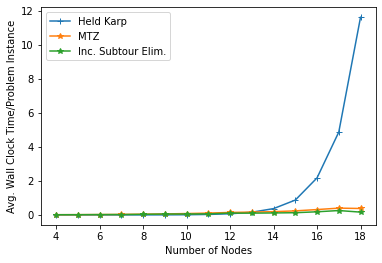

time: 169 ms (started: 2023-11-07 18:47:07 +00:00)


In [20]:
plt.plot(range(4, 19), average_hk, '-+', label='Held Karp')
plt.plot(range(4, 19), average_mtz, '-*', label='MTZ')
plt.plot(range(4, 19), average_st_elim, '-*', label='Inc. Subtour Elim.')
plt.legend()
plt.xlabel('Number of Nodes')
plt.ylabel('Avg. Wall Clock Time/Problem Instance')
plt.show()

Surprisingly, the algorithm that performs best in practice is the one that should theoretically have the worst time complexity: the integer linear programming approach based on sub-tour elimination. Note that there are many issues with our comparison: we are not using a particularly efficient ILP solver. Commercial solvers such as Gurobi will be much faster than the open source solver we are using. Also, our implementation of the Held-Karp algorithm can benefit from many improvements such as better data stucture for the memo table.

However, solving TSPs exactly is now possible for very large instances. For instance, the [Concorde TSP solver](https://www.math.uwaterloo.ca/tsp/concorde.html) can solve TSP instances with as many as [85900 vertices](https://www.math.uwaterloo.ca/tsp/pla85900/index.html) arising from a circuit design application.

# That's all folks!